In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# Data loading and exploration

In [2]:
df = pd.read_csv('AB_NYC_2019.csv')
len(df)

48895

In [3]:
df.head()


id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

In [4]:
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Text(0, 0.5, 'Something')

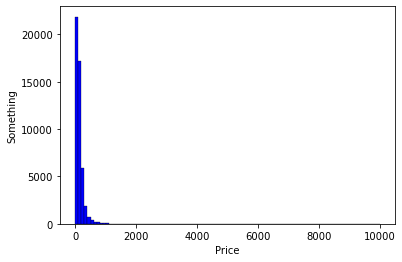

In [5]:
plt.figure(figsize=(6, 4))
sns.histplot(df.price, bins=100, color='blue', alpha=1)
plt.xlabel('Price')
plt.ylabel('Something')

The price feature follows a clear long-tail distribution.

# Data preparation

In [6]:
base = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

## Question 1

In [7]:
df[base].isnull().sum()

latitude                              0
longitude                             0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

## Question 1 answer

The feature `reviews_per_month` contains 10052 missing values.

## Question 2

In [8]:
df['minimum_nights'].describe()

count    48895.000000
mean         7.029962
std         20.510550
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64

In [9]:
df['minimum_nights'].median()

3.0

## Question 2 answer

The median for `minimum_nights` is 3.

# Data split, targets

In [10]:
np.random.seed(42) # nice

n = len(df)

n_val = int(0.2*n)
n_test = int(0.2*n)
n_train = n - n_val - n_test

# creates list of index and shuffles them
idx = np.arange(n)
np.random.shuffle(idx)

# shuffled dataframe
df_shuffled = df.iloc[idx]

# splits
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled[n_train+n_val:].copy()

# targets
y_train_orig = df_train.price.values
y_val_orig = df_val.price.values
y_test_orig = df_test.price.values

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

# remove targets from datasets
del df_train['price']
del df_val['price']
del df_test['price']

## Question 3

First, we must find the mean of `reviews_per_month` in the train dataset

In [11]:
feat_mean = df_train.reviews_per_month.mean()
print(feat_mean)

1.3685492094777056


Option 1: fill null values with `0`

Option 2: fill null values with the mean

In [12]:
# option 1
#df_op1 = df_train.fillna(0)
op1 = 0

# option 2
#df_op2 = df_train.fillna(feat_mean)
op2 = feat_mean

Defining the prepare/train/rmse functions

In [31]:
def prepare_X(df, fill):
    df = df.copy()
    features = base.copy()

    df_num = df[features]

    df_num = df_num.fillna(fill)
    X = df_num.values

    return X

def train_lr_no_reg(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T @ X
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv @ X.T @ y

    return w[0], w[1:]

def rmse(y, y_pred):
    #print(f'y type: {y.dtype}')
    #print(f'y_pred type: {y_pred.dtype}')
    error = y_pred - y
    #print(error)
    mse = (error ** 2).mean()
    #print(mse)
    return np.sqrt(mse)

def predict(w0, w, X):
    return w0 + X @ w

Training

In [14]:
X_op1 = prepare_X(df_train, op1)
w_0_op1, w_op1 = train_lr_no_reg(X_op1, y_train)

X_op2 = prepare_X(df_train, op2)
w_0_op2, w_op2 = train_lr_no_reg(X_op2, y_train)

Evaluating

In [15]:
#y_pred_op1 = w_0_op1 + X_op1 @ w_op1
#y_pred_op2 = w_0_op2 + X_op2 @ w_op2
y_pred_op1 = predict(w_0_op1, w_op1, X_op1)
y_pred_op2 = predict(w_0_op2, w_op2, X_op2)

In [16]:
rmse1 = rmse(y_train, y_pred_op1)
rmse2 = rmse(y_train, y_pred_op2)

print(f'RMSE option 1: {round(rmse1,2)}')
print(f'RMSE option 2: {round(rmse2,2)}')

RMSE option 1: 0.64
RMSE option 2: 0.64


In [17]:
# Eval dataset
X_val1 = prepare_X(df_val, op1)
# we don't recalculate the mean for the feature
X_val2 = prepare_X(df_val, op2)

y_val_op1 = predict(w_0_op1, w_op1, X_val1)
y_val_op2 = predict(w_0_op2, w_op2, X_val2)

rmseval1 = rmse(y_val, y_val_op1)
rmseval2 = rmse(y_val, y_val_op2)

print(f'RMSE validation option 1: {round(rmseval1, 2)}')
print(f'RMSE validation option 2: {round(rmseval2, 2)}')

RMSE validation option 1: 0.64
RMSE validation option 2: 0.64


## Question 3 answer
Both options 1 and 2 seem to be equally good.

## Question 4

Defininig the training function with regularization

In [18]:
def train_lr_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T @ X
    reg = r * np.eye(XTX.shape[0])
    XTX += reg
    
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv @ X.T @ y

    return w[0], w[1:]

In [19]:
regs = np.array([0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10])

In [22]:
# we already have our prepared X with 0's; it's option 1
# sanity check: let's compute it again
X_train = prepare_X(df_train, 0)
X_val = prepare_X(df_val, 0)
#res = []
for r in regs:
    w0, w = train_lr_reg(X_train, y_train, r)
    y_pred = predict(w0, w, X_train)
    y_val_pred = predict(w0, w, X_val)
    rmse_train = rmse(y_train, y_pred)
    rmse_val = rmse(y_val, y_val_pred)
    #res.append([w0, w, y_pred, y_val_pred, rmse_train, rmse_val, r])
    print(f'r = {r}, RMSE train = {round(rmse_train,2)}, RMSE val = {round(rmse_val, 2)}')
    #print(f'r = {r}, RMSE train = {rmse_train}, RMSE val = {rmse_val}')

r = 0.0, RMSE train = 0.64, RMSE val = 0.64
r = 1e-06, RMSE train = 0.64, RMSE val = 0.64
r = 0.0001, RMSE train = 0.64, RMSE val = 0.64
r = 0.001, RMSE train = 0.64, RMSE val = 0.64
r = 0.01, RMSE train = 0.65, RMSE val = 0.66
r = 0.1, RMSE train = 0.68, RMSE val = 0.68
r = 1.0, RMSE train = 0.68, RMSE val = 0.68
r = 5.0, RMSE train = 0.68, RMSE val = 0.68
r = 10.0, RMSE train = 0.68, RMSE val = 0.68


## Question 4 answer

There are multiple r values with good results: 0, 0.000001, 0.001, 0.01.

The smallest one is 0.000001

## Question 5

In [23]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [37]:
scores = []
for seed in seeds:
    np.random.seed(seed)

    # creates list of index and shuffles them
    idx = np.arange(n)
    np.random.shuffle(idx)

    # shuffled dataframe
    df_shuffled = df.iloc[idx]

    # splits
    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled[n_train+n_val:].copy()

    # targets
    y_train_orig = df_train.price.values
    y_val_orig = df_val.price.values
    y_test_orig = df_test.price.values

    y_train = np.log1p(df_train.price.values)
    y_val = np.log1p(df_val.price.values)
    y_test = np.log1p(df_test.price.values)

    # remove targets from datasets
    del df_train['price']
    del df_val['price']
    del df_test['price']

    # getting ready to train
    X_train = prepare_X(df_train, 0)
    w0, w = train_lr_no_reg(X_train, y_train)

    X_val = prepare_X(df_val, 0)
    y_pred = predict(w0, w, X_val)

    error = rmse(y_val, y_pred)

    scores.append(error)

scores = np.array(scores)
std = np.std(scores)
print(f'RMSE standard deviation: {round(std, 3)}')
    

RMSE standard deviation: 0.008


## Question 5

Standard deviation for the RMSE scores is 0.008

## Question 6

In [40]:
np.random.seed(9)

# creates list of index and shuffles them
idx = np.arange(n)
np.random.shuffle(idx)

#shuffled dataframe
df_shuffled = df.iloc[idx]

# splits
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled[n_train+n_val:].copy()

# targets
y_train_orig = df_train.price.values
y_val_orig = df_val.price.values
y_test_orig = df_test.price.values

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

# remove targets from datasets
del df_train['price']
del df_val['price']
del df_test['price']

# combine datasets
df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = np.concatenate([y_train, y_val])

# getting ready to train
X_full_train = prepare_X(df_full_train, 0)
w0, w = train_lr_reg(X_full_train, y_full_train, 0.001)

# predict and error
X_test = prepare_X(df_test, 0)
y_pred = predict(w0, w, X_test)

error = rmse(y_test, y_pred)

print(f'RMSE on full train dataset: {round(error, 2)}')

RMSE on full train dataset: 0.65


## Question 6 answer

RMSE for the combined train and val datasets is 0.65